# Cognitive Age Prediction with Structural and Functional MRI

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Functions

In [2]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve, ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def run_ridge(data, subjects_data, alphas=None, train_sizes=None):
    """Helper for running ridge resgression.
    
    Parameters
    ----------
    data : pandas.DataFrame
        Features to be used for predictions.
        
    subjects_data : pandas.DataFrame
        Information about subjects from CamCAN dataset.
        
    alphas : numpy.ndarray
        Values for parameter alpha to be tested using RidgeCV. Default is
        np.logspace(start=-3, stop=1, num=50, base=10.0).
        
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if alphas is None:
        alphas = np.logspace(start=-3, stop=1, num=50, base=10.0)
    if train_sizes is None:
        train_sizes = np.linspace(.1, 1.0, 5)
    
    # prepare data, subjects age
    data_rnd = data.sample(frac=1)
    subjects = data_rnd.index.values
    y = subjects_data.loc[data_rnd.index.values].age.values
    X = data_rnd.values

    reg = make_pipeline(StandardScaler(), RidgeCV(alphas))
    cv_ss = ShuffleSplit(n_splits=CV_STEPS, random_state=42)

    mae = cross_val_score(reg, X, y, scoring='neg_mean_absolute_error', cv=cv_ss)
    r2 = cross_val_score(reg, X, y, scoring='r2', cv=cv_ss)
    y_pred = cross_val_predict(reg, X, y, cv=CV_STEPS)
    
    train_sizes, train_scores, test_scores = \
        learning_curve(reg, X, y, cv=CV_STEPS, train_sizes=train_sizes, scoring="neg_mean_absolute_error")

    return y, y_pred, mae, r2, train_sizes, train_scores, test_scores, subjects


def plot_pred(y, y_pred, mae, title='Prediction vs Measured'):
    """Plot predicted values vs real values."""
    plt.figure()
    plt.title(title)
    plt.scatter(y, y_pred,  edgecolor='black')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '-', lw=3, color='green')
    plt.plot([y.min(), y.max()], [y.min() - mae, y.max() - mae], 'k--', lw=3, color='red')
    plt.plot([y.min(), y.max()], [y.min() + mae, y.max() + mae], 'k--', lw=3, color='red')
    plt.xlabel('chronological age')
    plt.ylabel('predicted age')
    plt.grid()
    plt.show()

    
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning Curves', ylim=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------        
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Numbers of training examples that has been used to generate the learning curve.
        
    train_scores : array, shape (n_ticks, n_cv_folds)
        Scores on training sets.

    test_scores : array, shape (n_ticks, n_cv_folds)
        Scores on test set.

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_scores = -train_scores
    test_scores = -test_scores
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    plt.show()


def plot_barchart(mae_std, bar_text_indent=2):
    """Plot bar chart.
    
    Parameters
    ----------
    mae_std : dict(str, (number, number))
        Dictionary with labels and corresponding mae and std.
    bar_text_indent : number
        Indent from the bar top for labels displaying mae and std, measures in years.
    """
    objects = tuple(reversed(sorted(mae_std.keys())))
    y_pos = np.arange(len(objects))
    mae = tuple(mae_std[k][0] for k in objects)
    std = tuple(mae_std[k][1] for k in objects)

    fig, axs = plt.subplots()
    #axs.grid(zorder=0)
    axs.barh(y_pos, mae, align='center', xerr=std)

    # remove frame around the plot
    axs.spines["top"].set_visible(False)
    axs.spines["bottom"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["left"].set_visible(False)

    for i, v in enumerate(mae):
        axs.text(v + bar_text_indent, i - 0.05, f'{round(v, 2)} ({round(std[i], 2)})', color='blue', bbox=dict(facecolor='white'))

    plt.yticks(y_pos, objects)
    plt.xlabel('Absolute Prediction Error (Years)')
    plt.title('Age Prediction Performance of Different Modalities')

    plt.show()

## Structural MRI

### Read Data

In [3]:
import pandas as pd

# read information about subjects
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)

subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# read features

area_data = pd.read_hdf('../../data/structural/structural_data.h5', 
                           key='area')
thickness_data = pd.read_hdf('../../data/structural/structural_data.h5',
                               key='thickness')
volume_data = pd.read_hdf('../../data/structural/structural_data.h5',
                            key='volume')

volume_data.head()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
Measure:volume,,,,,,,,,,,,,,,,,,,,,
CC310256,16443.3,215.0,14808.5,56803.4,7378.4,3956.5,5018.7,2464.6,1684.8,2822.3,...,1.194657e+06,1.160384e+06,1158424.0,1847752.0,0.718849,0.988205,16.0,7.0,23.0,1.869806e+06
CC110033,6018.2,145.2,13938.6,56055.7,8523.9,3604.6,4557.6,2008.8,971.2,1426.7,...,1.030259e+06,1.014403e+06,1011785.0,1596489.0,0.757157,1.029559,41.0,23.0,64.0,1.550654e+06
CC110037,5150.4,226.8,14923.5,59652.3,7732.1,3223.5,4647.4,2154.4,773.3,1478.8,...,1.032711e+06,1.022294e+06,1019858.0,1618468.0,0.782415,1.072228,19.0,30.0,49.0,1.509444e+06
CC110098,6299.5,269.5,14468.0,59900.4,7368.8,3976.3,5239.7,1884.4,880.3,1790.9,...,1.091133e+06,1.079604e+06,1076145.0,1732368.0,0.740368,1.031667,12.0,28.0,40.0,1.679193e+06
CC110126,2711.6,352.6,16216.5,57535.4,7946.3,3431.7,4875.8,1994.7,726.2,1233.2,...,1.094727e+06,1.088829e+06,1086463.0,1628306.0,0.769026,1.009764,21.0,23.0,44.0,1.612561e+06


In [5]:
area_data = area_data.dropna()
thickness_data = thickness_data.dropna()
volume_data = volume_data.dropna()

### Training and Prediction

In [6]:
CV_STEPS = 10
# store mae, std for the summary plot
mae_std = {}

#### Area

MAE: 10.35
MAE STD: 0.89


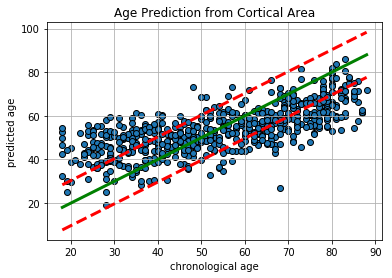

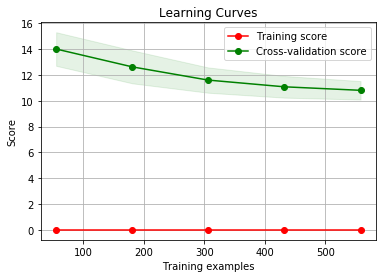

In [7]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = \
    run_ridge(area_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

mae_std['Cortical Surface Area'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from Cortical Area')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Thickness

MAE: 7.42
MAE STD: 0.41


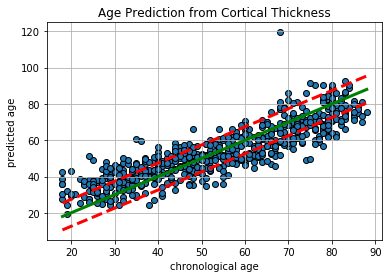

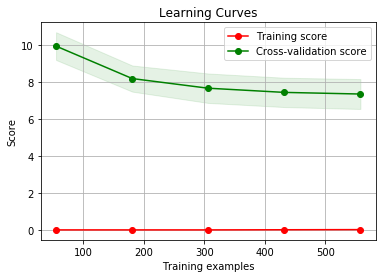

In [8]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = run_ridge(thickness_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

mae_std['Cortical Thickness'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from Cortical Thickness')
plot_learning_curve(train_sizes, train_scores, test_scores)

#### Volume

MAE: 6.76
MAE STD: 0.45


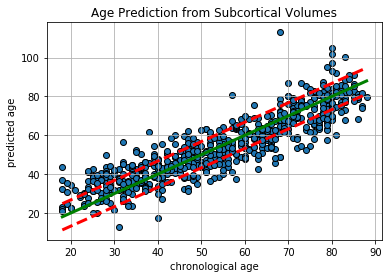

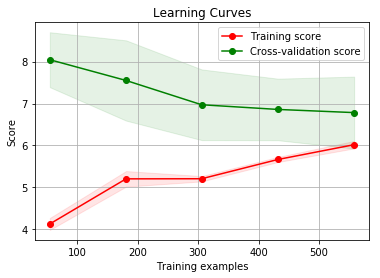

In [9]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, sbjs = run_ridge(volume_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

mae_std['Subcortical Volumes'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from Subcortical Volumes')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Functional MRI

### BASC 197

In [10]:
# read connectivity data
connect_data = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='basc197')
connect_data.head()

,0,1,2,3,4,5,6,7,8,9,...,19493,19494,19495,19496,19497,19498,19499,19500,19501,19502
CC110033,0.096697,-0.140008,0.067199,-0.013200,0.040234,-0.163020,-0.029214,0.156358,0.078821,0.087680,...,-0.037457,0.044814,0.021185,-0.036576,-0.054100,-0.002762,0.053630,0.022528,-0.006503,0.273724
CC110037,-0.591520,-0.088332,-0.723872,0.101235,-0.012502,-0.854274,0.029541,0.023450,-0.067513,-1.492769,...,-0.067943,-0.124460,-0.034104,-0.103519,0.098355,-0.021281,0.136260,-0.073003,0.048019,-0.070249
CC110045,-0.042581,-0.176352,-0.037048,0.141138,-0.055788,-0.007159,0.041272,0.144073,-0.075119,0.061303,...,0.037748,-0.021896,0.097779,0.053294,0.060940,-0.000433,-0.062330,-0.039093,0.033913,-0.148330
CC110069,-0.442311,-0.079525,-0.141859,0.023382,-0.061421,-0.358688,0.069646,-0.011345,0.072415,0.156324,...,0.035603,-0.036768,-0.023163,0.023483,-0.037131,-0.039623,-0.011263,0.056086,-0.144799,-0.178823
CC110087,-0.097007,-0.133572,0.074754,0.099027,-0.034863,-0.310058,0.031366,-0.022870,0.071330,-0.108389,...,-0.073019,-0.152082,0.123719,-0.041476,0.067740,0.094479,0.045866,0.040174,-0.045647,0.129202


MAE: 5.71
MAE STD: 0.60


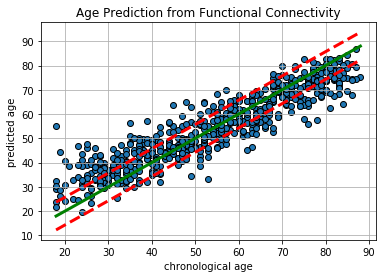

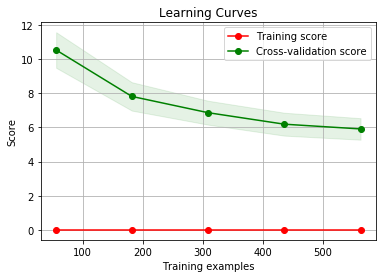

In [11]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = run_ridge(connect_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

mae_std['Connectivity Matrix, BASC 197'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

### MODL 256

In [12]:
# read connectivity data
connect_data = pd.read_hdf('../../data/connectivity/connect_data_tangent.h5',
                              key='modl256')
connect_data.head()

,0,1,2,3,4,5,6,7,8,9,...,32886,32887,32888,32889,32890,32891,32892,32893,32894,32895
CC110033,0.074408,-0.018078,-0.026110,-0.035737,0.026987,-0.148206,-0.123741,0.043818,-0.007511,0.028245,...,0.033294,0.047502,0.026974,-0.018982,0.119100,0.139546,-0.001772,0.049109,0.009093,-0.208286
CC110037,-1.691638,-0.026637,-0.530353,0.047946,-0.010420,-1.973813,-0.068899,-0.057347,-0.048387,0.615105,...,-0.008444,-0.012884,0.050008,0.042905,0.058089,-0.024558,0.064888,-0.070759,0.024871,-1.646669
CC110045,0.129928,0.083970,-0.255726,-0.051040,0.090631,-0.166786,0.005209,0.121638,-0.003998,-0.167915,...,-0.010775,-0.043265,0.014613,-0.004538,-0.020235,0.050549,0.285926,-0.061542,0.206019,0.149908
CC110069,-0.155261,-0.004314,-0.298256,-0.103225,0.001456,-0.616323,-0.002113,0.057129,-0.043140,0.176846,...,-0.032800,0.072003,-0.247339,0.149980,-0.059462,-0.071107,-0.107166,0.025952,-0.043589,0.311891
CC110087,-0.304658,-0.012165,-0.093857,0.011350,0.101019,-0.086796,-0.099032,-0.083703,-0.038678,0.065644,...,0.035628,-0.133997,0.058017,-0.014234,-0.035109,-0.067293,-0.054121,-0.024550,-0.095122,-0.023328


MAE: 5.96
MAE STD: 0.72


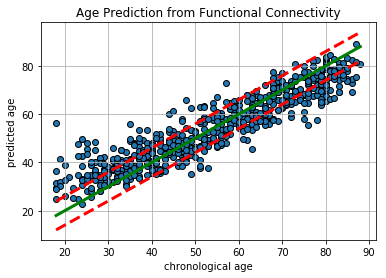

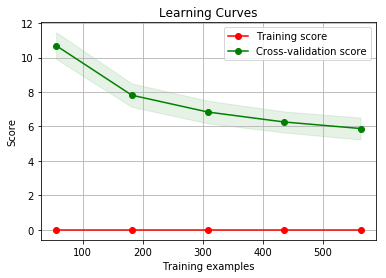

In [13]:
y, y_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores, _ = run_ridge(connect_data, subjects_data)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

mae_std['Connectivity Matrix, MODL 256'] = (mae, std)

plot_pred(y, y_pred, mae, title='Age Prediction from Functional Connectivity')
plot_learning_curve(train_sizes, train_scores, test_scores)

## Summary

### Results from Liem2016

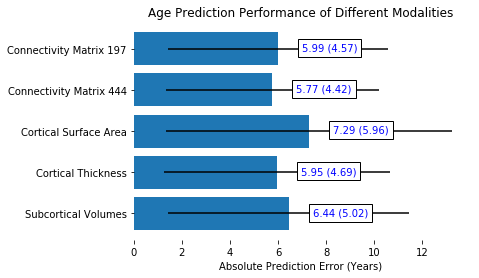

In [14]:
mae_std_liem = {"Connectivity Matrix 197": (5.99, 4.57),
                "Connectivity Matrix 444": (5.77, 4.42),
                "Cortical Thickness": (5.95, 4.69),
                "Cortical Surface Area": (7.29, 5.96),
                "Subcortical Volumes": (6.44, 5.02)}
plot_barchart(mae_std_liem, bar_text_indent=1)

### Results for CamCAN

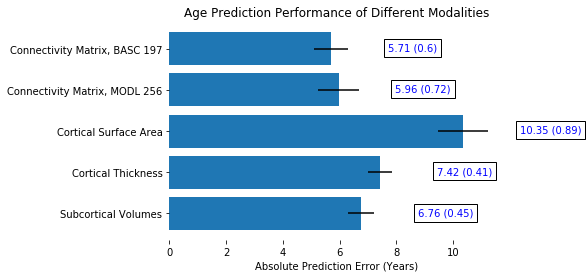

In [15]:
plot_barchart(mae_std)